In [2]:
from basic_utils import *
import datetime

On cuda:0
Figure directory exists.


In [2]:
class CyDataset(Dataset):
    def __init__(self):

        self.D = []
        self.L = []
                
        
        with open('/datacommons/carlsonlab/srs108/old/ol/Beijing_clean.pkl', "rb") as fp:
            for station in tqdm(pkl.load(fp)):
                self.L.append(tuple((station['Image'][:,:,:3], station['PM25'])))
#                 for datapoint in station:
#                     luck_img = datapoint['Image'][:,:,:3]
#                     if luck_img.shape == (224, 224,3):  
#                         self.L.append(tuple((luck_img, datapoint['PM'])))

        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_clean.pkl', "rb") as fp:
            for station in tqdm(pkl.load(fp)):
                self.D.append(tuple((station['Image'][:,:,:3], station['PM25'])))
                
        self.D = random.choices(self.D, k= len(self.L))
        
    def __len__(self): return (len(self.D))
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

            #Delhi normalization
        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.Pad(16),
                            transforms.ToTensor(),
#                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        d_img = self.D[idx][0]
        d_img = transform(d_img)        
        l_img = self.L[idx][0]
        l_img = transform(l_img)
        
        sample = {
              'D': d_img,
              'D pm' : torch.tensor(self.D[idx][1]),
              'L': l_img,
              'L pm' : torch.tensor(self.L[idx][1])
        }
        return sample

In [3]:
tr = CyDataset()

In [4]:
train, val = train_test_split(tr,test_size=0.2, random_state=69)

In [30]:
dataloader = DataLoader(
    train,
    batch_size=5, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=1, # 1
    shuffle=True)

In [6]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
# criterion_PM = torch.nn.MSELoss()

In [7]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 6 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)
D_ft = FeatureDiscriminator()

# C_A = Multi_City_CNN()
# C_A.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/dlm4.pt'))
# C_A.to(device)

# D_ft = FeatureDiscriminator()
# D_ft.to(device)

# C_B = LeNet(3)
# C_B.to(device)
print()

In [8]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
        
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()
#     criterion_PM.cuda()

In [9]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)
print()

In [10]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)
optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)
# optimizer_C_A = torch.optim.Adam(
#     C_A.parameters(), lr=lr, betas=(b1, b2)
# )

In [11]:
def sample_images(city1, city2, dataloader, e, i, show = False, save=False):
    source = next(iter(dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = source['D'].type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = source['L'].type(Tensor)
    fake_A = G_BA(real_B).detach()

    recon_A = G_BA(fake_B).detach()
    recon_B = G_AB(fake_A).detach()

    real_A = make_grid(real_A, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_B = make_grid(fake_B, nrow=5, normalize=True, scale_each=True, padding=1)
    real_B = make_grid(real_B, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_A = make_grid(fake_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_A = make_grid(recon_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_B = make_grid(recon_B, nrow=5, normalize=True, scale_each=True, padding=1)
    
    # Set individual titles
    titles = [f'Real {city1}', f'Fake {city1}', f'Recon {city1}', f'Real {city2}', f'Fake {city2}', f'Recon {city2}']
    
    plt.figure(figsize=(12, 9))
    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.02, hspace=0.02)  # Adjust spacing

    for index, grid in enumerate([real_A, fake_B, recon_A, real_B, fake_A, recon_B]):
        plt.subplot(1, 6, index+1)
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title(titles[index])
        plt.axis('off')

    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    
    if show:
        plt.show()
    plt.close()


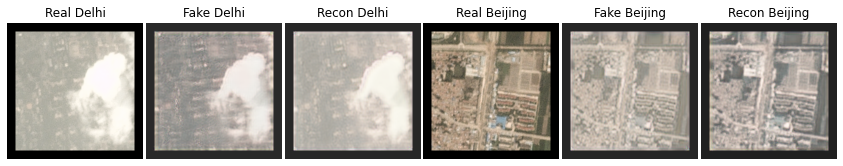

[Epoch 1/1] [Batch 100/2071] [D loss : 0.297551] [G loss : 1.339077 - (adv : 0.314357, cycle : 0.051595, identity : 0.050159)]


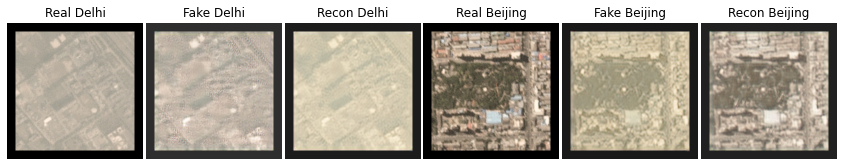

[Epoch 1/1] [Batch 200/2071] [D loss : 0.165202] [G loss : 1.276852 - (adv : 0.444358, cycle : 0.040499, identity : 0.045003)]


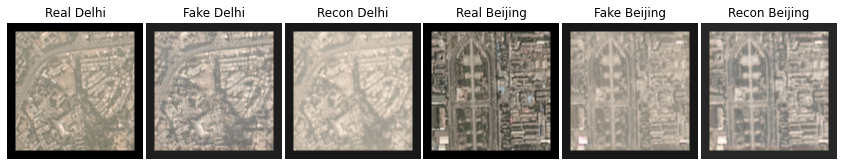

[Epoch 1/1] [Batch 300/2071] [D loss : 0.155475] [G loss : 1.559717 - (adv : 0.483270, cycle : 0.055872, identity : 0.047673)]


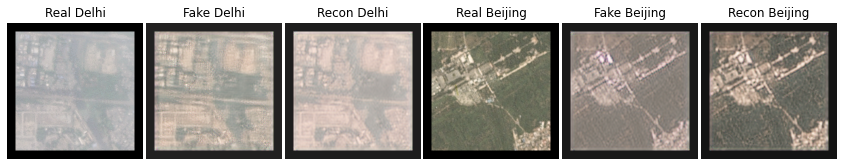

[Epoch 1/1] [Batch 400/2071] [D loss : 0.228999] [G loss : 1.380829 - (adv : 0.295089, cycle : 0.056251, identity : 0.048396)]


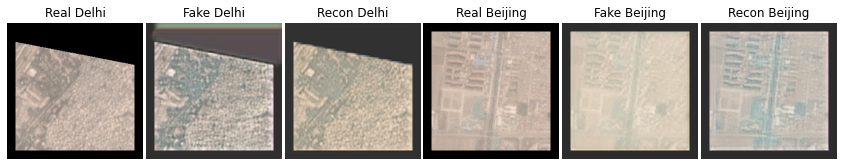

[Epoch 1/1] [Batch 500/2071] [D loss : 0.157713] [G loss : 1.576975 - (adv : 0.372700, cycle : 0.061777, identity : 0.055524)]


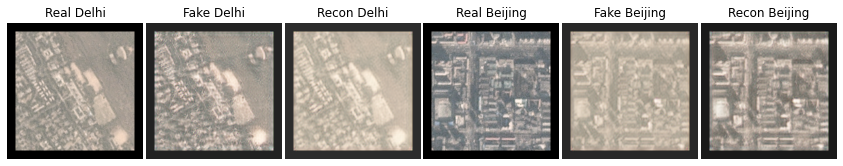

[Epoch 1/1] [Batch 600/2071] [D loss : 0.205811] [G loss : 1.279301 - (adv : 0.524219, cycle : 0.039391, identity : 0.032843)]


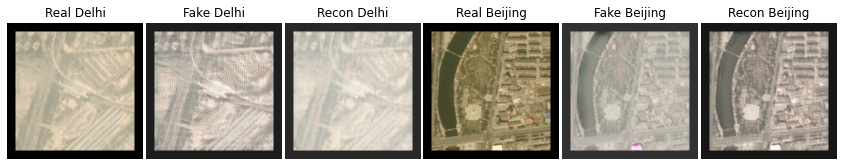

[Epoch 1/1] [Batch 700/2071] [D loss : 0.201397] [G loss : 1.128124 - (adv : 0.434591, cycle : 0.031332, identity : 0.044711)]


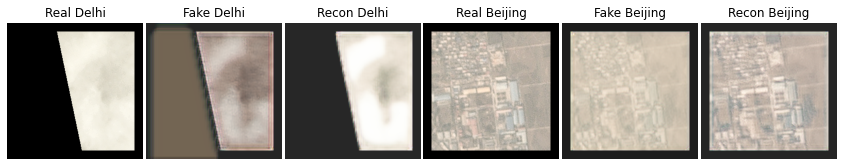

[Epoch 1/1] [Batch 800/2071] [D loss : 0.257828] [G loss : 1.258610 - (adv : 0.309530, cycle : 0.045156, identity : 0.054349)]


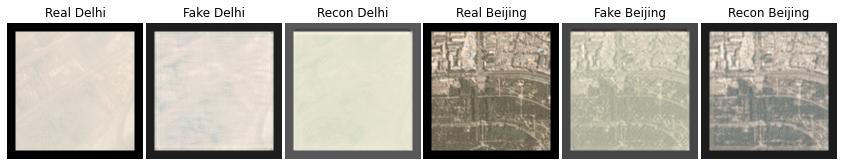

[Epoch 1/1] [Batch 900/2071] [D loss : 0.195135] [G loss : 1.464148 - (adv : 0.418252, cycle : 0.052536, identity : 0.051570)]


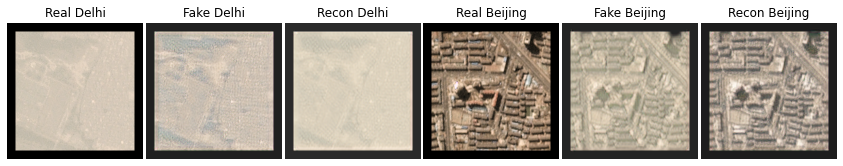

[Epoch 1/1] [Batch 1000/2071] [D loss : 0.187696] [G loss : 1.471225 - (adv : 0.279690, cycle : 0.058982, identity : 0.061362)]


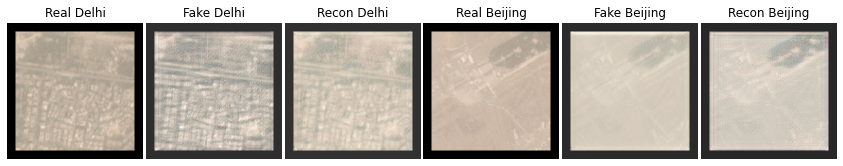

[Epoch 1/1] [Batch 1100/2071] [D loss : 0.190815] [G loss : 1.629754 - (adv : 0.409586, cycle : 0.061422, identity : 0.059769)]


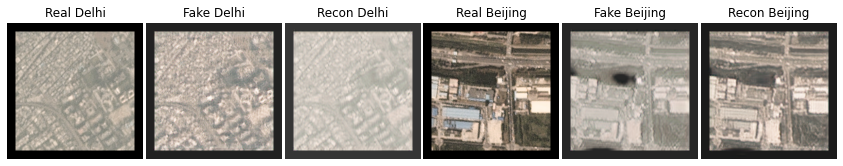

[Epoch 1/1] [Batch 1200/2071] [D loss : 0.142915] [G loss : 1.784242 - (adv : 0.536864, cycle : 0.063935, identity : 0.057672)]


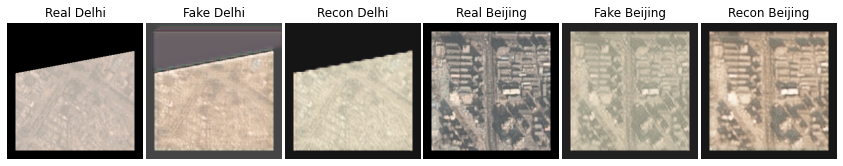

[Epoch 1/1] [Batch 1300/2071] [D loss : 0.147387] [G loss : 1.633290 - (adv : 0.606834, cycle : 0.051171, identity : 0.051777)]


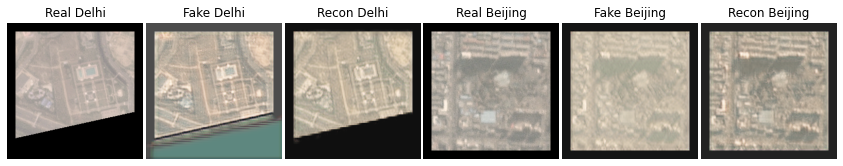

[Epoch 1/1] [Batch 1400/2071] [D loss : 0.186146] [G loss : 1.336860 - (adv : 0.317702, cycle : 0.050261, identity : 0.053048)]


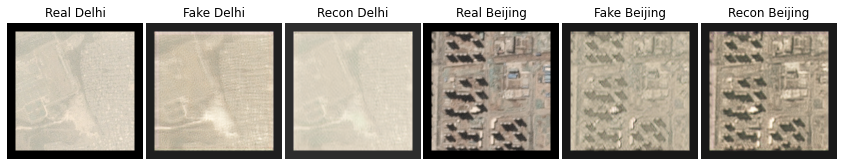

[Epoch 1/1] [Batch 1500/2071] [D loss : 0.200060] [G loss : 1.243928 - (adv : 0.413514, cycle : 0.042418, identity : 0.038830)]


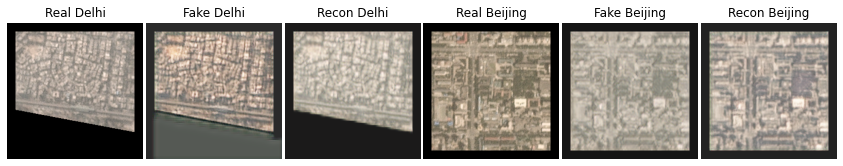

[Epoch 1/1] [Batch 1600/2071] [D loss : 0.255533] [G loss : 1.335677 - (adv : 0.330452, cycle : 0.048357, identity : 0.055973)]


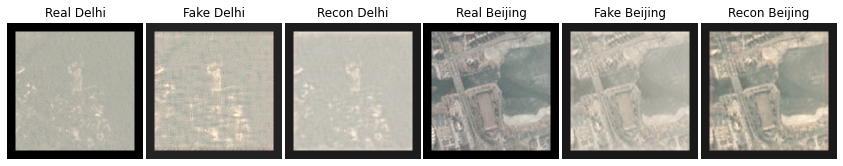

[Epoch 1/1] [Batch 1700/2071] [D loss : 0.234263] [G loss : 1.278202 - (adv : 0.253329, cycle : 0.051208, identity : 0.051352)]


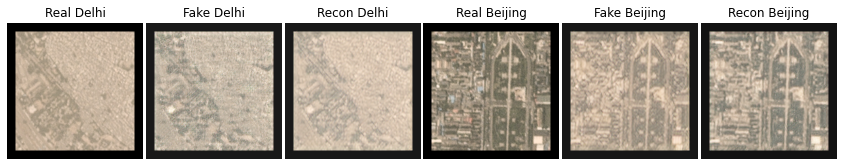

[Epoch 1/1] [Batch 1800/2071] [D loss : 0.148884] [G loss : 1.413348 - (adv : 0.460221, cycle : 0.048963, identity : 0.043736)]


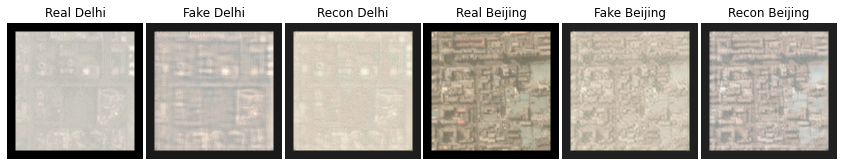

[Epoch 1/1] [Batch 1900/2071] [D loss : 0.164922] [G loss : 1.783004 - (adv : 0.728166, cycle : 0.054490, identity : 0.047496)]


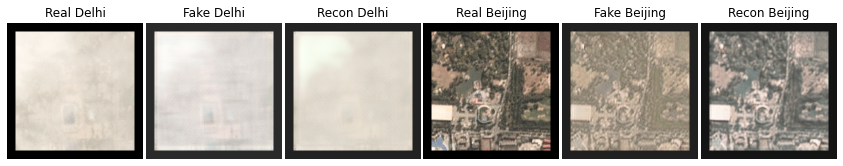

[Epoch 1/1] [Batch 2000/2071] [D loss : 0.227394] [G loss : 1.297736 - (adv : 0.419167, cycle : 0.044892, identity : 0.041036)]



In [35]:
history = {'epoch':[],'G_loss':[],'adv_loss': [],'cyc_loss': [], 'idt_loss': [], 'D_loss':[],'D_fake': [], 'D_real': [], 'batch':[]}
best_D_loss = 1e6
best_G_loss = 1e6
best_sem_loss = 1e7
n_epochs = 300
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate((dataloader)): #tqdm
        
        # Set model input
        real_A = batch['D'].type(Tensor)
        real_B = batch['L'].type(Tensor)
        lbl_A = batch['D pm'].type(Tensor)
        
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        fake_A = G_BA(real_B)

        
#         pm_from_real_source = C_A(real_A).squeeze(1)
#         pm_from_real_target = C_A(real_B).squeeze(1)
        
#         pm_from_fake_target = C_A(fake_B.detach()).squeeze(1)
#         pm_from_fake_source = C_A(fake_A.detach()).squeeze(1)
        
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        recov_B = G_AB(fake_A)
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.

# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        

# ------> Total Loss
        loss_G = loss_GAN + (15.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        # Semantic Loss
#         print(f'pm from real source: {pm_from_real_source.item()}\npm from fake target: {pm_from_fake_target.item()}\n\npm from real target: {pm_from_real_target.item()}\npm from fake source: {pm_from_fake_source.item()}\n')

#         loss_sem_AB = criterion_PM(pm_from_fake_target, lbl_A)
#         loss_sem_BA = criterion_PM(pm_from_fake_source, pm_from_real_target)
        
#         loss_G += loss_sem_AB + loss_sem_BA
        
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real_A = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake_A = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real_A + loss_fake_A)/2
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real_B = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake_B = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real_B + loss_fake_B)/2
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
    
        d_real = loss_real_A + loss_real_A
        d_fake = loss_fake_B + loss_fake_B

# -----------------
# Train C_A  # forward only real source image through semantic classifier
# -----------------
#         optimizer_C_A.zero_grad()
        
#         loss_sem = criterion_PM(pm_from_real_source, lbl_A)
#         loss_sem.backward()
        
#         optimizer_C_A.step()
# -----------------
# Model Saving
# -----------------    
        if loss_D <= best_D_loss:
            best_D_loss = loss_D
            torch.save({'D_B': D_B.state_dict(), 'D_A': D_A.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/best_D.pt')
            
        if loss_G <= best_G_loss:
            best_G_loss = loss_G
            torch.save({ 'G_AB': G_AB.state_dict(),'G_BA': G_BA.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/best_G.pt')
              
        
# -----------------
# Show Progress
# -----------------
        if (i+1) % 1000 == 0:
            with torch.no_grad():
#                 sample_images('Delhi', 'Lucknow', dataloader, epoch, i, show = True, save = True)

                sample_images('Delhi', 'Beijing',val_dataloader, epoch, i, show = False, save = True)
#                 print(f'pm from real source: {pm_from_real_source.item()}\npm from fake target: {pm_from_fake_target.item()}\n\npm from real target: {pm_from_real_target.item()}\npm from fake source: {pm_from_fake_source.item()}\n')

                print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                        %(epoch+1,n_epochs,       # [Epoch -]
                          i+1,len(dataloader),   # [Batch -]
                          loss_D.item(),       # [D loss -]
                          loss_G.item(),       # [G loss -]
                          loss_GAN.item(),     # [adv -]
                          loss_cycle.item(),   # [cycle -]
#                           loss_sem.item(),     # [sem -]
                          loss_identity.item(),# [identity -]
                     ))
            
            history['G_loss'].append(loss_G.item())
            history['D_loss'].append(loss_D.item())
            history['batch'].append(i+1)
            history['epoch'].append(epoch+1)
            history['adv_loss'].append(loss_GAN.item())
            history['cyc_loss'].append(loss_cycle.item())
            history['idt_loss'].append(loss_identity.item())
            history['D_fake'].append(d_fake.item())
            history['D_real'].append(d_real.item())

    now = datetime.datetime.now()
    print(f"Epoch {e + 1}/{n_epochs} finished at {now.time()}")

In [30]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)

In [3]:
df = pd.read_csv('/datacommons/carlsonlab/srs108/cycle/phase_two/history.csv')

In [5]:
df

epoch    G_loss  adv_loss  cyc_loss  idt_loss    D_loss    D_fake  \
0        1  1.730438  0.361879  0.064478  0.080279  0.237807  0.712800   
1        1  1.204984  0.202219  0.047607  0.057733  0.278234  0.587942   
2        2  1.343600  0.576350  0.037606  0.040632  0.249583  0.332226   
3        2  1.043874  0.383905  0.031788  0.036630  0.241589  0.199936   
4        3  0.993817  0.380725  0.031218  0.028964  0.235835  0.121530   
..     ...       ...       ...       ...       ...       ...       ...   
595    298  1.202098  0.838210  0.019699  0.013681  0.056963  0.063822   
596    299  1.031563  0.645559  0.020813  0.014763  0.065129  0.190902   
597    299  1.188832  0.794930  0.021332  0.014784  0.054977  0.089889   
598    300  1.058558  0.775390  0.014954  0.011773  0.044614  0.070782   
599    300  1.228593  0.823295  0.021988  0.015097  0.048317  0.051891   

       D_real  batch  
0    0.658684   1000  
1    0.243871   2000  
2    0.927259   1000  
3    0.445513   2000  
4    0.186040   1000  
..        ...    ...  
595  0.150705   2000  
596  0.085888   1000  
597  0.068789   2000  
598  0.116166   1000  
599  0.133082   2000  

[600 rows x 9 columns]

In [8]:
def gen_dis_loss(genloss, disloss, iters, save = True, fig_name=''):
#     epoch = range(epochs)
    fig, ax = plt.subplots(1,1, figsize = (6,6))   
    ax.plot(iters, genloss, color='b', linewidth=0.5, label='Generator')
    ax.plot(iters, disloss, color='r', linewidth=0.5, label='Discriminator')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Generator and Discriminator Loss')
    ax.legend()
    plt.show()
    if save==True:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')

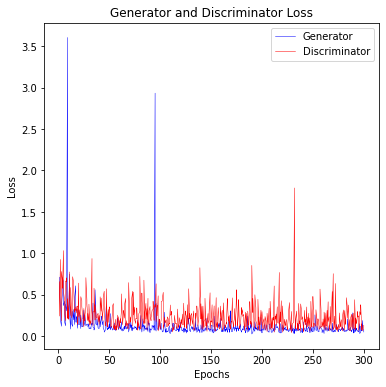

In [10]:
gen_dis_loss(df['D_fake'], df['D_real'], df['epoch'], save=False)

In [7]:
def trainloss(mainloss, iters, save = True, fig_name=''):
    fig, ax = plt.subplots(1,1, figsize = (6,6))   
    ax.plot(iters, mainloss, color='b', linewidth=0.5)
    ax.set_xlabel('Iters')
    ax.set_ylabel('Loss')
    plt.show()
    if save==True:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')
        

In [ ]:
def gen_loss(cycloss, , iters, save = True, fig_name=''):
    fig, ax = plt.subplots(1,1, figsize = (6,6))   
    ax.plot(iters, mainloss, color='b', linewidth=0.5)
    ax.set_xlabel('Iters')
    ax.set_ylabel('Loss')
    plt.show()
    if save==True:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')
        

In [25]:
# trainloss(df['idt_loss'], df['epoch'], save=False)

In [26]:
# max(df['G_loss'])

In [ ]:
# min(df)